# Ensemble Learning

The approach here is to fit some "weak learners" and then combine them to create a stronger learner.

We rely on the principal models from classical statistics

In [2]:
import pandas as pd
from statsforecast import StatsForecast
from statsforecast.models import HoltWinters,AutoARIMA,AutoETS,MSTL,IMAPA
from utils import preprocess
from tqdm import tqdm

df = pd.read_csv('data/01_input_history.csv')
df_train_null, df_train_inactive, df_train_active, df_validation = preprocess.preprocess_ex1(df)

In [3]:
# Forecasting horizon
H = 12  # 12 months ahead
# Set up the model
sf = StatsForecast(
    models=[
        HoltWinters(season_length=12, error_type="A"),
        MSTL(season_length=12),
        IMAPA(),
        AutoETS(season_length=12),
        AutoARIMA(season_length=12),
    ],
    freq='MS',
    n_jobs=-1
)

# Fit the model
sf.fit(
    df_train_active[['unique_id', 'ds', 'Quantity']],
    target_col='Quantity',
    )

StatsForecast(models=[HoltWinters,MSTL,IMAPA,AutoETS,AutoARIMA])

In [10]:
y_hat = sf.predict(h=H)

In [11]:
y_hat['EnsambleAverage'] = y_hat[['HoltWinters', 'MSTL', 'IMAPA', 'AutoETS', 'AutoARIMA']].mean(axis=1)
y_hat['EnsambleMedian'] = y_hat[['HoltWinters', 'MSTL', 'IMAPA', 'AutoETS', 'AutoARIMA']].median(axis=1)
y_hat

,unique_id,ds,HoltWinters,MSTL,IMAPA,AutoETS,AutoARIMA,EnsambleAverage,EnsambleMedian
0,Australia_BrightBreeze Insect Repellent,2023-01-01,846.067078,856.686279,871.140137,873.887695,873.916687,864.339539,871.140137
1,Australia_BrightBreeze Insect Repellent,2023-02-01,842.904175,853.537720,871.140137,873.887695,873.916687,863.077271,871.140137
2,Australia_BrightBreeze Insect Repellent,2023-03-01,857.736328,867.138367,871.140137,873.887695,873.916687,868.763855,871.140137
3,Australia_BrightBreeze Insect Repellent,2023-04-01,879.504761,889.352417,871.140137,873.887695,873.916687,877.560364,873.916687
4,Australia_BrightBreeze Insect Repellent,2023-05-01,896.190125,903.263611,871.140137,873.887695,873.916687,883.679565,873.916687
...,...,...,...,...,...,...,...,...,...
4855,United Kingdom_SunShield SPF 50 Lotion,2023-08-01,1880.781982,1801.173828,1892.751465,1864.466919,1864.516724,1860.738037,1864.516724
4856,United Kingdom_SunShield SPF 50 Lotion,2023-09-01,1998.426636,1918.415771,1892.751465,1864.466919,1864.516724,1907.715454,1892.751465
4857,United Kingdom_SunShield SPF 50 Lotion,2023-10-01,1931.850586,1878.424805,1892.751465,1864.466919,1864.516724,1886.402100,1878.424805
4858,United Kingdom_SunShield SPF 50 Lotion,2023-11-01,1937.193604,1882.329834,1892.751465,1864.466919,1864.516724,1888.251709,1882.329834


In [12]:
df_validation['Average'] = 0
df_validation['Median'] = 0

for id in tqdm(df_train_active['unique_id'].unique()):
    df_validation.loc[df_validation['unique_id'] == id, 'Average'] = y_hat.loc[y_hat['unique_id'] == id, 'EnsambleAverage'].values.astype(int)
    df_validation.loc[df_validation['unique_id'] == id, 'Median'] = y_hat.loc[y_hat['unique_id'] == id, 'EnsambleMedian'].values.astype(int)
    

100%|██████████| 405/405 [00:00<00:00, 777.22it/s]


In [15]:
def restore_original_format(date_column):
    return date_column.dt.strftime('%b%Y')
df_validation['Month'] = restore_original_format(df_validation['ds'])

In [17]:
df_validation[['Quantity','Product','Month','Country']].to_csv('submissions/validation_classical.csv', index=False)

df_forecastAverage = df_validation[['Average','Country','Product','Month']].copy()
df_forecastAverage.rename(columns={'Average': 'Quantity'}, inplace=True)
df_forecastAverage[['Quantity','Product','Month','Country']].to_csv('submissions/submission_Average.csv', index=False)

df_forecastMedian = df_validation[['Median','Country','Product','Month']].copy()
df_forecastMedian.rename(columns={'Median': 'Quantity'}, inplace=True)
df_forecastMedian[['Quantity','Product','Month','Country']].to_csv('submissions/submission_Median.csv', index=False)


# Plot check

In [19]:
sub_df = pd.read_csv('submissions/submission_Average.csv')
sub_df['unique_id'] = sub_df['Country'] + '_' + sub_df['Product']
sub_df['ds'] = pd.to_datetime(sub_df['Month'], format='%b%Y')

In [41]:
# # from utilsforecast.plotting import plot_series
# # plot_series(df_train_active,max_ids=30,target_col='Quantity')

In [42]:
sub_HW = pd.read_csv('submissions/submission_HW.csv')
sub_HW['unique_id'] = sub_HW['Country'] + '_' + sub_HW['Product']
sub_HW['ds'] = pd.to_datetime(sub_HW['Month'], format='%b%Y')

In [50]:
df_train_active['unique_id'].unique()

array(['Japan_FreshStart Toothpaste', 'Japan_BriteBite Toothbrush',
       'Japan_OralEase Gel', 'Japan_DentalDefense Toothpaste',
       'Japan_MorningBreeze Gum Care', 'Japan_OralEase Plus Toothbrush',
       'Japan_SparklingGlow Toothpaste', 'Japan_SoftStep Shaving Cream',
       'Japan_GentleGlow Face Lotion', 'Japan_HydraHydrate Hand Cream',
       'Japan_SilkSmooth Exfoliating Scrub',
       'Japan_CleanSkin Acne Treatment', 'Japan_SunShield SPF 50 Lotion',
       'Japan_Calming Creme Relaxant Bath', 'Japan_RadiantRose Face Mask',
       'Japan_SilkySkin Moisturizing Cream',
       'Japan_MorningMist Deodorant', 'Japan_Hydrating Honey Body Lotion',
       'Japan_FreshFusion Detergent',
       'Japan_SoothingSoft Fabric Softener',
       'Japan_SparklingClean All-Purpose Cleaner',
       'Japan_FreshFusion Diaper Rash Remedy',
       'Japan_PurePore Baby Lotion', 'Japan_SilkySkin Baby Cream',
       'Japan_SoftStep Baby Shampoo',
       'Japan_RadiantRose Baby Massage Oil',
      

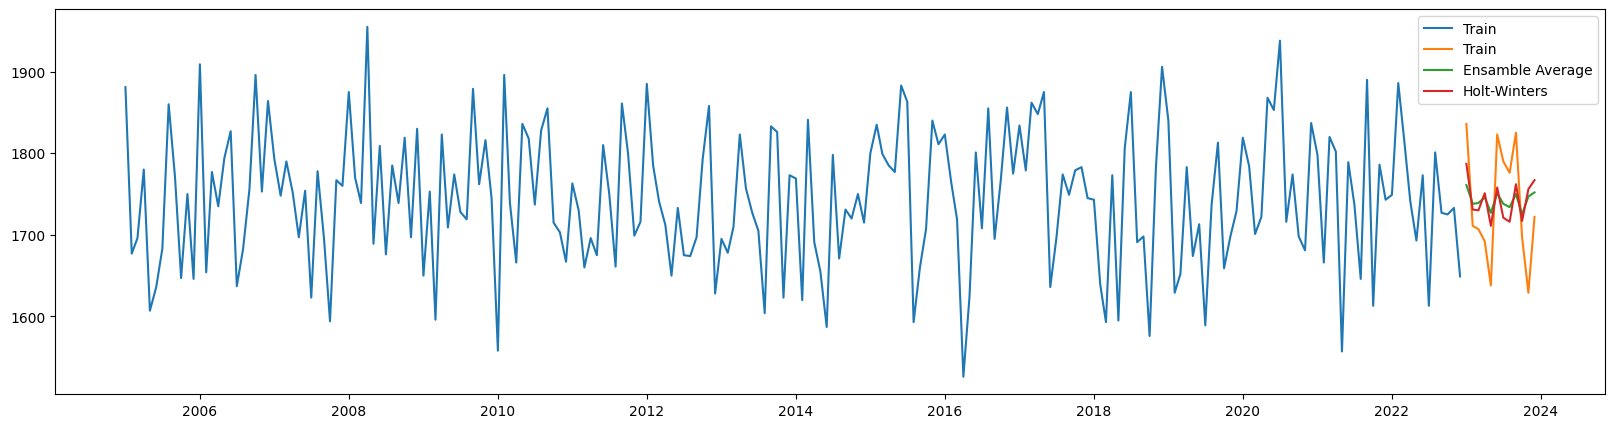

In [52]:
id = "Japan_SparklingClean All-Purpose Cleaner"
#id = 'Brazil_RadiantRose Face Mask'
import matplotlib.pyplot as plt
plt.figure(figsize=(20, 5))
plt.plot(df_train_active.loc[df_train_active['unique_id'] == id, 'ds'],
         df_train_active.loc[df_train_active['unique_id'] == id, 'Quantity'], label='Train')

plt.plot(df_validation.loc[df_validation['unique_id'] == id, 'ds'],
         df_validation.loc[df_validation['unique_id'] == id, 'Quantity'], label='Train')

plt.plot(sub_df.loc[sub_df['unique_id'] == id, 'ds'],
         sub_df.loc[sub_df['unique_id'] == id, 'Quantity'], label='Ensamble Average')

plt.plot(sub_HW.loc[sub_HW['unique_id'] == id, 'ds'],
         sub_HW.loc[sub_HW['unique_id'] == id, 'Quantity'], label='Holt-Winters')

plt.legend()